In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import gurobipy as gp
from gurobipy import GRB
import json
from copy import copy

In [4]:
status_codes = {
    1: 'LOADED',
    2: 'OPTIMAL',
    3: 'INFEASIBLE',
    4: 'INF_OR_UNBD',
    5: 'UNBOUNDED',
    6: 'CUTOFF',
    7: 'ITERATION_LIMIT',
    8: 'NODE_LIMIT',
    9: 'TIME_LIMIT',
    10: 'SOLUTION_LIMIT',
    11: 'INTERRUPTED',
    12: 'NUMERIC',
    13: 'SUBOPTIMAL',
    14: 'INPROGRESS',
    15: 'USER_OBJ_LIMIT'
}

In [5]:
rng = np.random.default_rng(43)

# Scaling Bounds: Observed Set

Use sample to identify the set of observed counts $x$ (above a certain threshold of observations) and unobserved counts (up to M >> maximum observed)

From these construct p(obs) and p(unobs) via sum over sets, and use to construct scaling bounds and CME constraints

In [6]:
def bootstrap(sample, beta, N, tau, drop=False):
    """
    Bootstrap estimate of probabilities of all states in the sample
    Set bounds outside tau threshold truncation to [0, 1]

    sample: integer sample
    N: number of bootstrap resamples
    tau: truncation threshold
    drop: if true, values outside truncation are removed from the sample before bootstrap
    """

    # min and max states
    xmin, xmax = int(sample.min()), int(sample.max())

    # count # observations of each state
    sample_counts = np.bincount(sample, minlength=(xmax + 1))

    # observed states (# obs >= tau)
    observed_states = np.where(sample_counts >= tau)[0]
    '''NOTE: changed to >=, was > in prev work'''

    # unobserved states (# obs < tau)
    unobserved_states = np.where(sample_counts < tau)[0]

    # (optional) remove 'unobserved' states from sample before bootstrapping
    if drop:

        # boolean mask (to keep)
        mask = np.isin(sample, observed_states)
        
        # remove (from sample and capture)
        sample = sample[mask]
        beta = beta[mask]

    # confidence intervals
    prob_intervals = np.empty((2, xmax + 1))
    fm_intervals = np.empty((2, xmax + 1))

    # resample
    prob_resamples = rng.choice(sample, size=(N, len(sample)))

    # for all x
    for x in range(xmin, xmax + 1):

        # unobserved: set to [0, 1]
        if x in unobserved_states:

            prob_intervals[:, x] = [0, 1]
            fm_intervals[:, x] = [0, 1]

        # observed: bootstrap
        else:

            '''probs'''
            # proportion of x per resample
            prob_estimates = (prob_resamples == x).mean(axis=1)
            # interval
            prob_intervals[:, x] = np.quantile(prob_estimates, [0.025, 0.975])

            '''fms'''
            # capture for cells with x observed counts
            beta_x = beta[sample == x]
            # resample
            beta_resamples = rng.choice(beta_x, size=(N, len(beta_x)))
            # estimate E[beta|m]
            fm_estimate = beta_resamples.mean(axis=1)
            # quantile for confidence intervals
            fm_intervals[:, x] = np.quantile(fm_estimate, [0.025, 0.975], axis=0)

    # convert state arrays to list
    observed_states = observed_states.tolist()
    unobserved_states = unobserved_states.tolist()

    return observed_states, unobserved_states, prob_intervals, fm_intervals

In [7]:
def optimize_downsampled_scaling(observed_states, unobserved_states, M, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=300, dist_opt=True, UB=1):
    '''
    Downsampled Scaling Optimization

    observed states: set of states observed (above a threshold #)
    unobserved states: set of states not observed (")
    M: consider additional unobserved states up to this value
    prob_intervals: Bootstrap CI on probabilities
    fm_intervals: Bootstrap CI on fms
    
    silent: optimization log toggle
    printing: solution print toggle
    time_limit: optimization time limit
    dist_opt: toggle for optimizing probabilities
    
    UB: upper bound on unobserved mass
    '''

    # copy sets
    observed_states = copy(observed_states)
    unobserved_states = copy(unobserved_states)

    # errors for small M
    if M in observed_states:
        print(f"M = {M} too low: in observed set")
        raise Exception

    if M in unobserved_states:
        print(f"M = {M} too low: in unobserved set")
        raise Exception
    
    # add states to unobserved set up to M
    for x in range(M + 1):
        if x in observed_states:
            continue
        elif x in unobserved_states:
            continue
        else:
            unobserved_states.append(x)
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(M + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(M + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # observed mass
            p_obs = gp.quicksum([p[x] for x in observed_states])

            # unobserved mass
            p_unobs = gp.quicksum([p[x] for x in unobserved_states])

            # unobserved mass upper bound
            model.addConstr(p_unobs <= UB, name="Unobserved_ub")

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # scaled observed probability bounds
            model.addConstrs(
                (
                    p[x] <= prob_intervals[1, x] * p_obs
                    for x in observed_states
                ),
                name="prob_ub"
            )
            model.addConstrs(
                (
                    p[x] >= prob_intervals[0, x] * p_obs
                    for x in observed_states
                ),
                name="prob_lb"
            )

            # f rate bounds
            model.addConstrs(
                (
                    f[x] <= fm_intervals[1, x]
                    for x in observed_states
                ),
                name="f_ub"
            )
            model.addConstrs(
                (
                    f[x] >= fm_intervals[0, x]
                    for x in observed_states
                ),
                name="f_lb"
            )

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            model.addConstr(
                z == p[1] - k_tx * f[0] * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, M)
                ),
                name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((M + 1, 2))
                for x in range(M + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

In [8]:
def optimize_downsampled_standard(observed_states, unobserved_states, M, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=300, dist_opt=True):
    '''
    Downsampled Standard Optimization

    observed states: set of states observed (above a threshold #)
    unobserved states: set of states not observed (")
    M: consider additional unobserved states up to this value
    prob_intervals: Bootstrap CI on probabilities
    fm_intervals: Bootstrap CI on fms
    
    silent: optimization log toggle
    printing: solution print toggle
    time_limit: optimization time limit
    dist_opt: toggle for optimizing probabilities
    '''

    # copy sets
    observed_states = copy(observed_states)
    unobserved_states = copy(unobserved_states)

    # errors for small M
    if M in observed_states:
        print(f"M = {M} too low: in observed set")
        raise Exception

    if M in unobserved_states:
        print(f"M = {M} too low: in unobserved set")
        raise Exception
    
    # add states to unobserved set up to M
    for x in range(M + 1):
        if x in observed_states:
            continue
        elif x in unobserved_states:
            continue
        else:
            unobserved_states.append(x)

    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(M + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(M + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx", lb=0, ub=K)

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # scaled observed probability bounds
            model.addConstrs(
                (
                    p[x] <= prob_intervals[1, x]
                    for x in observed_states
                ),
                name="prob_ub"
            )
            model.addConstrs(
                (
                    p[x] >= prob_intervals[0, x]
                    for x in observed_states
                ),
                name="prob_lb"
            )

            # f rate bounds
            model.addConstrs(
                (
                    f[x] <= fm_intervals[1, x]
                    for x in observed_states
                ),
                name="f_ub"
            )
            model.addConstrs(
                (
                    f[x] >= fm_intervals[0, x]
                    for x in observed_states
                ),
                name="f_lb"
            )

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # CME
            model.addConstr(
                z == p[1] - k_tx * f[0] * p[0],
                name="CME_0"
            )

            model.addConstrs(
                (
                    z == k_tx * f[x - 1] * p[x - 1] + (x + 1) * p[x + 1] - (k_tx * f[x] + x) * p[x] for x in range(1, M)
                ),
                name="CME_x"
            )

            # optimize
            solution = {}
            model.setObjective(k_tx, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min'] = model.ObjVal
            except:
                solution['min'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max'] = model.ObjVal
            except:
                solution['max'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx in ({solution['min']}, {solution['max']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            if dist_opt:
                p_bounds = np.zeros((M + 1, 2))
                for x in range(M + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds

    return solution

## Example

In [9]:
# settings
k = 2
tau = 5
N = 1000
n = 1000

# simulate & bootstrap
sample = rng.poisson(k, size=n)
beta = rng.beta(1, 2, size=n) #np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

In [10]:
print(f"Observed {obs_states}")
print(f"Unobserved {unobs_states}")

Observed [0, 1, 2, 3, 4]
Unobserved [5, 6]


In [11]:
# settings
M = 30

# optimize
solution = optimize_downsampled_scaling(
    obs_states,
    unobs_states,
    M,
    prob_intervals,
    fm_intervals,
    dist_opt= False,
    time_limit=30,
    UB = 0.1
)

k_tx in (1.7168865990127784, 2.217704509232905), status OPTIMAL, OPTIMAL


In [12]:
# settings
M = 30

# optimize
solution = optimize_downsampled_standard(
    obs_states,
    unobs_states,
    M,
    prob_intervals,
    fm_intervals,
    dist_opt= False,
    time_limit=30,
)

k_tx in (1.7185160664961128, 2.230186643422683), status OPTIMAL, OPTIMAL


In [14]:
# compute true unobserved mass
p_obs = np.zeros(len(obs_states))
for b in beta:
    p_obs += scipy.stats.poisson.pmf(obs_states, b * k) / len(beta)
m_obs = sum(p_obs)
m_unobs = 1 - sum(p_obs)
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

p(obs) = 0.9958623235328571
p(unobs) = 0.0041376764671429145


## Vary M

In [15]:
# settings
k = 2
tau = 5
N = 1000
n = 1000

# simulate & bootstrap (no capture: beta = 1)
sample = rng.poisson(k, size=n)
beta = rng.beta(1, 2, size=n) #np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

print(f"Observed {obs_states}")
print(f"Unobserved {unobs_states}")

Observed [0, 1, 2, 3, 4]
Unobserved [5, 6]


In [16]:
M_range = [8, 10, 20, 30, 50, 100]
bounds = np.empty((2, len(M_range)))

for i, M in enumerate(M_range):

    # optimize
    solution = optimize_downsampled_standard(
        obs_states,
        unobs_states,
        M,
        prob_intervals,
        fm_intervals,
        dist_opt= False,
        time_limit=30,
        printing=False
    )

    # store
    bounds[0, i] = solution['min']
    bounds[1, i] = solution['max']

Text(0, 0.5, '$k_{tx}$')

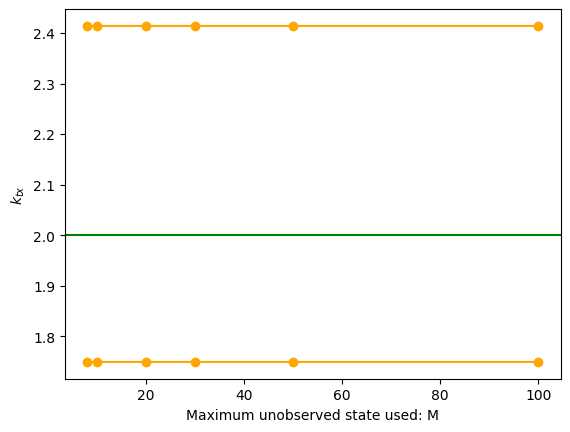

In [17]:
plt.plot(M_range, bounds[0, :], color="orange", label="Standard Optimization")
plt.plot(M_range, bounds[1, :], color="orange")
plt.scatter(M_range, bounds[0, :], color="orange")
plt.scatter(M_range, bounds[1, :], color="orange")
plt.axhline(k, color="green", label="True value")
plt.xlabel("Maximum unobserved state used: M")
plt.ylabel(r"$k_{tx}$")

In [23]:
UB_range = [0.05, 0.1, 0.5, 1.0]
M_range = [8, 10, 20, 30, 50, 100]

scaling_bounds = np.empty((2, len(UB_range), len(M_range)))

for i, UB in enumerate(UB_range): 

    for j, M in enumerate(M_range):

        # optimize
        solution = optimize_downsampled_scaling(
            obs_states,
            unobs_states,
            M,
            prob_intervals,
            fm_intervals,
            dist_opt= False,
            time_limit=30,
            printing=False,
            UB = 1.0
        )

        # store
        scaling_bounds[0, i, j] = solution['min']
        scaling_bounds[1, i, j] = solution['max']

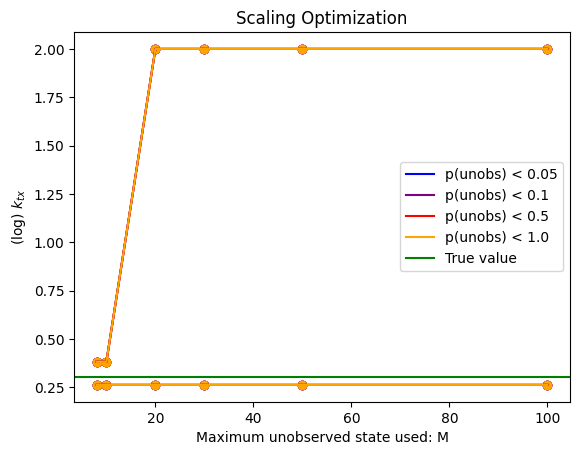

In [24]:
colours = ["blue", "purple", "red", "orange"]

for i, UB in enumerate(UB_range):
    plt.plot(M_range, np.log10(scaling_bounds[0, i, :]), color=colours[i], label=f"p(unobs) < {UB}")
    plt.plot(M_range, np.log10(scaling_bounds[1, i, :]), color=colours[i])
    plt.scatter(M_range, np.log10(scaling_bounds[0, i, :]), color=colours[i])
    plt.scatter(M_range, np.log10(scaling_bounds[1, i, :]), color=colours[i])

plt.axhline(np.log10(k), color="green", label="True value")
plt.title("Scaling Optimization")
plt.xlabel("Maximum unobserved state used: M")
plt.ylabel(r"(log) $k_{tx}$")
plt.legend()

## Sparse samples

### Small sample size

Observed [4, 5, 6, 8, 9, 10, 11, 12, 14]
Unobserved [0, 1, 2, 3, 7, 13]
p(obs) = 0.7432183044457605
p(unobs) = 0.25678169555423946


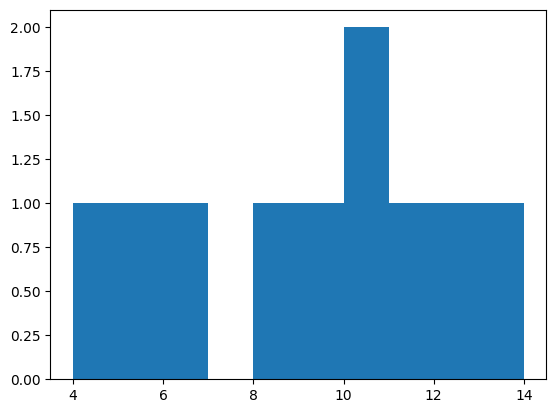

In [97]:
# settings
k = 10
tau = 1
N = 1000
n = 10

# simulate & bootstrap
sample = rng.poisson(k, size=n)
beta = np.ones(n) #rng.beta(1, 2, size=n) #np.ones(n)
sample_downsampled = rng.binomial(sample, beta)
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

# display
plt.hist(sample_downsampled);
print(f"Observed {obs_states}")
print(f"Unobserved {unobs_states}")

# compute true unobserved mass
p_obs = np.zeros(len(obs_states))
for b in beta:
    p_obs += scipy.stats.poisson.pmf(obs_states, b * k) / len(beta)
m_obs = sum(p_obs)
m_unobs = 1 - sum(p_obs)
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

In [100]:
# settings
M = 30

# optimize
solution = optimize_downsampled_standard(
    obs_states,
    unobs_states,
    M,
    prob_intervals,
    fm_intervals,
    dist_opt= False,
    time_limit=300,
)

k_tx in (0.0, 100.0), status OPTIMAL, OPTIMAL


In [101]:
# settings
M = 30
UB = 0.5

# optimize
solution = optimize_downsampled_scaling(
    obs_states,
    unobs_states,
    M,
    prob_intervals,
    fm_intervals,
    dist_opt= False,
    time_limit=300,
    UB = UB
)

k_tx in (4.790083782614558, 20.312330839158932), status OPTIMAL, OPTIMAL


### Varying sample size

In [425]:
n_list= [10, 50, 100, 250, 500, 1000, 2000, 5000]

bounds_standard = np.empty((2, len(n_list)))
bounds_scaling = np.empty((2, len(n_list)))

for i, n in enumerate(n_list):

    # settings
    k = 5
    tau = 3
    N = 1000

    if n == 10:
        tau = 1

    # simulate & bootstrap
    sample = rng.poisson(k, size=n)
    beta = np.ones(n) #rng.beta(1, 2, size=n) #np.ones(n)
    sample_downsampled = rng.binomial(sample, beta)
    obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

    # settings
    M = 30

    # optimize
    solution_standard = optimize_downsampled_standard(
        obs_states,
        unobs_states,
        M,
        prob_intervals,
        fm_intervals,
        dist_opt= False,
        time_limit=300,
        printing=False
    )

    bounds_standard[0, i] = solution_standard['min']
    bounds_standard[1, i] = solution_standard['max']

    # settings
    M = 30
    UB = 0.5

    # optimize
    solution_scaling = optimize_downsampled_scaling(
        obs_states,
        unobs_states,
        M,
        prob_intervals,
        fm_intervals,
        dist_opt= False,
        time_limit=300,
        UB = UB,
        printing=False
    )

    bounds_scaling[0, i] = solution_scaling['min']
    bounds_scaling[1, i] = solution_scaling['max']

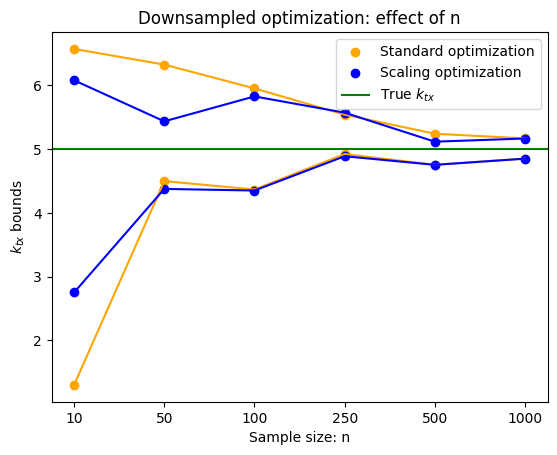

In [430]:
x_list = [i for i, _ in enumerate(n_list)][:6]

# standard
plt.scatter(x_list, bounds_standard[0, :6], color="orange", label="Standard optimization")
plt.scatter(x_list, bounds_standard[1, :6], color="orange")
plt.plot(x_list, bounds_standard[0, :6], color="orange")
plt.plot(x_list, bounds_standard[1, :6], color="orange")

# scaling
plt.scatter(x_list, bounds_scaling[0, :6], color="blue", label="Scaling optimization")
plt.scatter(x_list, bounds_scaling[1, :6], color="blue")
plt.plot(x_list, bounds_scaling[0, :6], color="blue")
plt.plot(x_list, bounds_scaling[1, :6], color="blue")

# plot
plt.xticks(x_list, n_list[:6])
plt.axhline(k, color="green", label=r"True $k_{tx}$")
plt.xlabel("Sample size: n")
plt.ylabel(r"$k_{tx}$ bounds")
plt.title("Downsampled optimization: effect of n")
plt.legend()

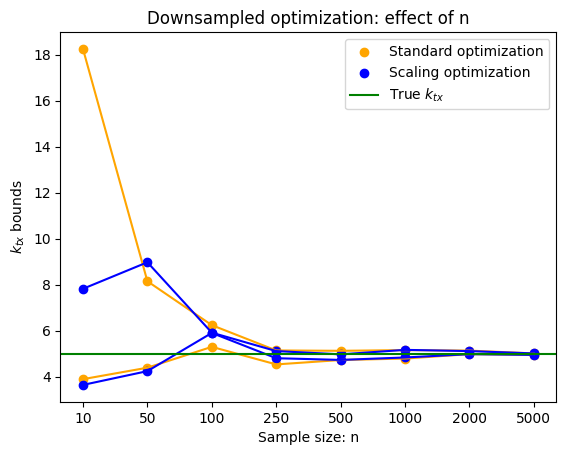

### Remove states

(Before) Observed [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20]
(Before) Unobserved [0, 1, 2, 19, 21]


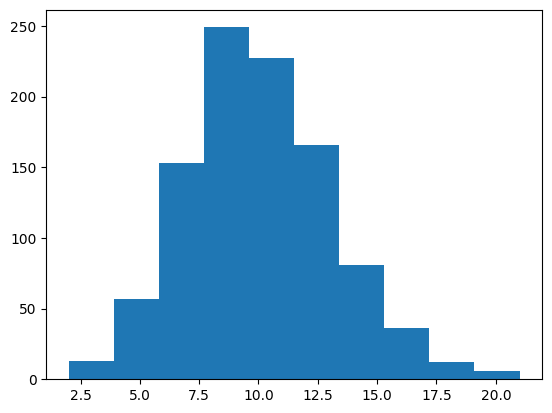

In [44]:
# settings
k = 10
tau = 5
N = 100
n = 1000

# simulate
sample = rng.poisson(k, size=n)
beta = np.ones(n) #rng.beta(1, 2, size=n) #np.ones(n)
sample_downsampled = rng.binomial(sample, beta)

# initial bootstrap
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap(sample_downsampled, beta, N, tau, drop=True)

# display
plt.hist(sample_downsampled);
print(f"(Before) Observed {obs_states}")
print(f"(Before) Unobserved {unobs_states}")

(After) Observed [3, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 20]
(After) Unobserved [0, 1, 2, 8, 10, 19, 21]


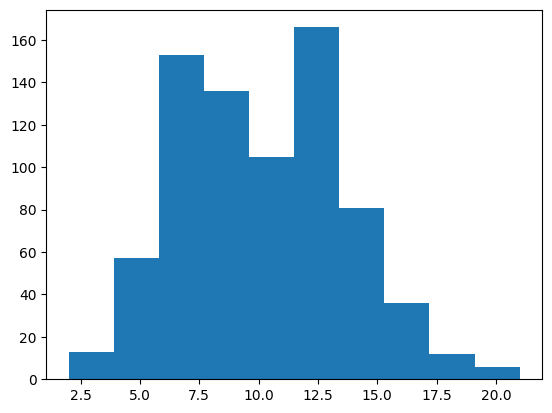

In [63]:
# states to remove
removed_states = [8, 10]

# remove states
idx = np.isin(sample_downsampled, removed_states)
sample_removed = sample_downsampled[~idx]
beta_removed = beta[~idx]

# re-compute bootstrap
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap(sample_removed, beta_removed, N, tau, drop=True)

# display
plt.hist(sample_removed);
print(f"(After) Observed {obs_states}")
print(f"(After) Unobserved {unobs_states}")

In [64]:
# compute true unobserved mass
p_obs = np.zeros(len(obs_states))
for b in beta:
    p_obs += scipy.stats.poisson.pmf(obs_states, b * k) / len(beta)
m_obs = sum(p_obs)
m_unobs = 1 - sum(p_obs)
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

p(obs) = 0.7542011131244778
p(unobs) = 0.2457988868755222


In [65]:
# settings
M = 30

# optimize
solution = optimize_downsampled_standard(
    obs_states,
    unobs_states,
    M,
    prob_intervals,
    fm_intervals,
    dist_opt= False,
    time_limit=30,
)

k_tx in (None, None), status INFEASIBLE, INFEASIBLE


In [69]:
# settings
M = 30
UB = 0.5

# optimize
solution = optimize_downsampled_scaling(
    obs_states,
    unobs_states,
    M,
    prob_intervals,
    fm_intervals,
    dist_opt= False,
    time_limit=30,
    UB = UB
)

k_tx in (9.649312074197656, 10.568254107675607), status OPTIMAL, OPTIMAL


## Notes

- vary UB to show effect

- vary M to show effect (seemed to make a difference? maybe only for UB = 1??)

___

- repeat same tests for UB and M effects (gridtest)

# Joint Distribution

Adapt the code for a joint distribution of counts $(x_{1}, x_{2})$, with observed and unobserved sets (up to a maximujm of $(M_{1}, M_{2})$ >> maximum pair observed)

In [115]:
from interaction_inference import simulation

In [265]:
def bootstrap_joint(sample, beta, N, tau, drop=False):
    """
    Bootstrap estimate of probabilities of all states in the sample
    Set bounds outside tau threshold truncation to [0, 1]

    sample: integer sample
    N: number of bootstrap resamples
    tau: truncation threshold
    drop: if true, values outside truncation are removed from the sample before bootstrap
    """

    # change to array
    sample = np.array(sample)

    # min and max states
    (xmin_1, xmin_2), (xmax_1, xmax_2) = sample.min(axis=0).tolist(), sample.max(axis=0).tolist()

    # map (x1, x2) pairs to integers: x2 + (xmax_2 + 1) * x1
    integer_sample = np.array([x[1] + (xmax_2 + 1)*x[0] for x in sample], dtype='uint32')

    # maxiumum of integer sample
    D = (xmax_1 + 1)*(xmax_2 + 1) - 1

    # count # observations of each state (x1, x2)
    sample_counts = np.bincount(integer_sample, minlength=D + 1).reshape(xmax_1 + 1, xmax_2 + 1)

    # observed states (# obs >= tau)
    obs_1, obs_2 = np.where(sample_counts >= tau)
    observed_states = list(zip(obs_1.tolist(), obs_2.tolist()))

    # unobserved states (# obs < tau)
    unobs_1, unobs_2 = np.where(sample_counts < tau)
    unobserved_states = list(zip(unobs_1.tolist(), unobs_2.tolist()))

    # (optional) remove 'unobserved' states from sample before bootstrapping
    if drop:

        # boolean mask (to keep)
        mask = (sample[:, None] == observed_states).all(axis=2).any(axis=1)
        
        # remove (from sample and capture)
        sample = sample[mask]
        beta = beta[mask]

    # confidence intervals
    prob_intervals = np.empty((2, xmax_1 + 1, xmax_2 + 1))
    fm_intervals = np.empty((2, xmax_1 + 1, xmax_2 + 1))

    # resample
    prob_resamples = rng.choice(sample, size=(N, len(sample)))

    # for all (x1, x2)
    for x1 in range(xmin_1, xmax_1 + 1):
        for x2 in range(xmin_2, xmax_2 + 1):

            # unobserved: set to [0, 1]
            if (x1, x2) in unobserved_states:

                prob_intervals[:, x1, x2] = [0, 1]
                fm_intervals[:, x1, x2] = [0, 1]

            # observed: bootstrap
            else:

                '''probs'''
                # proportion of x per resample
                prob_estimates = (prob_resamples == (x1, x2)).all(axis=2).mean(axis=1)
                # interval
                prob_intervals[:, x1, x2] = np.quantile(prob_estimates, [0.025, 0.975])

                '''fms'''
                # capture for cells with x observed counts
                beta_x = beta[(sample == (x1, x2)).all(axis=1)]
                # resample
                beta_resamples = rng.choice(beta_x, size=(N, len(beta_x)))
                # estimate E[beta|m]
                fm_estimate = beta_resamples.mean(axis=1)
                # quantile for confidence intervals
                fm_intervals[:, x1, x2] = np.quantile(fm_estimate, [0.025, 0.975], axis=0)
                
    return observed_states, unobserved_states, prob_intervals, fm_intervals

In [ ]:
def optimize_downsampled_scaling_joint(observed_states, unobserved_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=300, dist_opt=True, UB=1):
    '''
    Downsampled Scaling Optimization

    observed states: set of states observed (above a threshold #)
    unobserved states: set of states not observed (")
    M1, M2: consider additional unobserved states up to these values
    prob_intervals: Bootstrap CI on probabilities
    fm_intervals: Bootstrap CI on fms
    
    silent: optimization log toggle
    printing: solution print toggle
    time_limit: optimization time limit
    dist_opt: toggle for optimizing probabilities
    
    UB: upper bound on unobserved mass
    '''

    # copy sets
    observed_states = copy(observed_states)
    unobserved_states = copy(unobserved_states)

    # errors for small M
    if (M1, M2) in observed_states:
        print(f"(M1, M2) = {(M1, M2)} too low: in observed set")
        raise Exception

    if (M1, M2) in unobserved_states:
        print(f"(M1, M2) = {(M1, M2)} too low: in unobserved set")
        raise Exception
    
    # add states to unobserved set up to M
    for x1 in range(M1 + 1):
        for x2 in range(M2 + 1):
            if (x1, x2) in observed_states:
                continue
            elif (x1, x2) in unobserved_states:
                continue
            else:
                unobserved_states.append((x1, x2))
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(M1 + 1, M2 + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(M1 + 1, M2 + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx_1 = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx_1", lb=0, ub=K)
            k_tx_2 = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx_2", lb=0, ub=K)
            k_deg_1 = 1
            k_deg_2 = 1
            k_reg = model.addVar(vtype=GRB.CONTINUOUS, name="k_reg", lb=0, ub=K)

            # observed mass
            p_obs = gp.quicksum([p[x1, x2] for (x1, x2) in observed_states])

            # unobserved mass
            p_unobs = gp.quicksum([p[x1, x2] for (x1, x2) in unobserved_states])

            # unobserved mass upper bound
            model.addConstr(p_unobs <= UB, name="Unobserved_ub")

            # distributional constraint
            model.addConstr(p.sum() == 1, name="Distribution")

            # scaled observed probability bounds
            model.addConstrs(
                (
                    p[x1, x2] <= prob_intervals[1, x1, x2] * p_obs
                    for (x1, x2) in observed_states
                ),
                name="prob_ub"
            )
            model.addConstrs(
                (
                    p[x1, x2] >= prob_intervals[0, x1, x2] * p_obs
                    for (x1, x2) in observed_states
                ),
                name="prob_lb"
            )

            # f rate bounds
            model.addConstrs(
                (
                    f[x1, x2] <= fm_intervals[1, x1, x2]
                    for (x1, x2) in observed_states
                ),
                name="f_ub"
            )
            model.addConstrs(
                (
                    f[x1, x2] >= fm_intervals[0, x1, x2]
                    for (x1, x2) in observed_states
                ),
                name="f_lb"
            )

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # manually add x1 = x2 = 0 constraint (to avoid -1 terms)
            model.addConstr(
                z == k_deg_1 * p[1, 0] + \
                k_deg_2 * p[0, 1] + \
                k_reg * p[1, 1] - \
                (k_tx_1 * f[0, 0] + k_tx_2 * f[0, 0]) * p[0, 0],
                name="CME_d_0_0"
            )

            # manually add x1 = 0 constraints (to avoid -1 terms)
            model.addConstrs(
                (
                    z == k_tx_2 * f[0, x2 - 1] * p[0, x2 - 1] + \
                    k_deg_1 * p[1, x2] + \
                    k_deg_2 * (x2 + 1) * p[0, x2 + 1] + \
                    k_reg * (x2 + 1) * p[1, x2 + 1] - \
                    (k_tx_1 * f[0, x2] + k_tx_2 * f[0, x2] + k_deg_2 * x2) * p[0, x2]
                    for x2 in range(1, M2)
                ),
                name="CME_d_0_x2"
            )
            # manually add x2 = 0 constraints (to avoid -1 terms)
            model.addConstrs(
                (
                    z == k_tx_1 * f[x1 - 1, 0] * p[x1 - 1, 0] + \
                    k_deg_1 * (x1 + 1) * p[x1 + 1, 0] + \
                    k_deg_2 * p[x1, 1] + \
                    k_reg * (x1 + 1) * p[x1 + 1, 1] - \
                    (k_tx_1 * f[x1, 0] + k_tx_2 * f[x1, 0] + k_deg_1 * x1) * p[x1, 0]
                    for x1 in range(1, M1)
                ),
                name="CME_d_x1_0"
            )

            # add CME constraints
            model.addConstrs(
                (
                    z == k_tx_1 * f[x1 - 1, x2] * p[x1 - 1, x2] + \
                    k_tx_2 * f[x1, x2 - 1] * p[x1, x2 - 1] + \
                    k_deg_1 * (x1 + 1) * p[x1 + 1, x2] + \
                    k_deg_2 * (x2 + 1) * p[x1, x2 + 1] + \
                    k_reg * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1] - \
                    (k_tx_1 * f[x1, x2] + k_tx_2 * f[x1, x2] + k_deg_1 * x1 + k_deg_2 * x2 + k_reg * x1 * x2) * p[x1, x2]
                    for x1 in range(1, M1)
                    for x2 in range(1, M2)
                ),
                name="CME_d_x1_x2"
            )

            # optimize
            solution = {}

            # k_tx_1
            model.setObjective(k_tx_1, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min_k_tx_1'] = model.ObjVal
            except:
                solution['min_k_tx_1'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx_1, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max_k_tx_1'] = model.ObjVal
            except:
                solution['max_k_tx_1'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx_1 in ({solution['min_k_tx_1']}, {solution['max_k_tx_1']}), status {solution['min_status']}, {solution['max_status']}")

            # k_tx_2
            model.setObjective(k_tx_2, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min_k_tx_2'] = model.ObjVal
            except:
                solution['min_k_tx_2'] = None

            model.setObjective(k_tx_2, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max_k_tx_2'] = model.ObjVal
            except:
                solution['max_k_tx_2'] = None

            # display
            if printing:
                print(f"k_tx_2 in ({solution['min_k_tx_2']}, {solution['max_k_tx_2']}), status {solution['min_status']}, {solution['max_status']}")

            # k_reg
            model.setObjective(k_reg, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min_k_reg'] = model.ObjVal
            except:
                solution['min_k_reg'] = None

            model.setObjective(k_reg, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max_k_reg'] = model.ObjVal
            except:
                solution['max_k_reg'] = None

            # display
            if printing:
                print(f"k_reg in ({solution['min_k_reg']}, {solution['max_k_reg']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            '''
            if dist_opt:
                p_bounds = np.zeros((M + 1, 2))
                for x in range(M + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds
            '''

    return solution

In [315]:
def optimize_downsampled_standard_joint(observed_states, unobserved_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=300, dist_opt=True):
    '''
    Downsampled Standard Optimization

    observed states: set of states observed (above a threshold #)
    unobserved states: set of states not observed (")
    M1, M2: consider additional unobserved states up to these values
    prob_intervals: Bootstrap CI on probabilities
    fm_intervals: Bootstrap CI on fms
    
    silent: optimization log toggle
    printing: solution print toggle
    time_limit: optimization time limit
    dist_opt: toggle for optimizing probabilities
    '''

    # copy sets
    observed_states = copy(observed_states)
    unobserved_states = copy(unobserved_states)

    # errors for small M
    if (M1, M2) in observed_states:
        print(f"(M1, M2) = {(M1, M2)} too low: in observed set")
        raise Exception

    if (M1, M2) in unobserved_states:
        print(f"(M1, M2) = {(M1, M2)} too low: in unobserved set")
        raise Exception
    
    # add states to unobserved set up to M
    for x1 in range(M1 + 1):
        for x2 in range(M2 + 1):
            if (x1, x2) in observed_states:
                continue
            elif (x1, x2) in unobserved_states:
                continue
            else:
                unobserved_states.append((x1, x2))
    
    # WLS license
    options = json.load(open("../../../WLS_credentials.json"))

    # silent
    if silent:
        options['OutputFlag'] = 0

    # environment context
    with gp.Env(params=options) as env:

        # model context
        with gp.Model('test-construction', env=env) as model:

            # model settings
            model.Params.TimeLimit = time_limit
            K = 100

            # variables
            p = model.addMVar(shape=(M1 + 1, M2 + 1), vtype=GRB.CONTINUOUS, name="p", lb=0, ub=1)
            f = model.addMVar(shape=(M1 + 1, M2 + 1), vtype=GRB.CONTINUOUS, name="f", lb=0, ub=1)
            k_tx_1 = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx_1", lb=0, ub=K)
            k_tx_2 = model.addVar(vtype=GRB.CONTINUOUS, name="k_tx_2", lb=0, ub=K)
            k_deg_1 = 1
            k_deg_2 = 1
            k_reg = model.addVar(vtype=GRB.CONTINUOUS, name="k_reg", lb=0, ub=K)

            # observed mass
            #p_obs = gp.quicksum([p[x1, x2] for (x1, x2) in observed_states])

            # unobserved mass
            #p_unobs = gp.quicksum([p[x1, x2] for (x1, x2) in unobserved_states])

            # unobserved mass upper bound
            #model.addConstr(p_unobs <= UB, name="Unobserved_ub")

            # distributional constraint
            model.addConstr(p.sum() <= 1, name="Distribution")

            # scaled observed probability bounds
            model.addConstrs(
                (
                    p[x1, x2] <= prob_intervals[1, x1, x2]
                    for (x1, x2) in observed_states
                ),
                name="prob_ub"
            )
            model.addConstrs(
                (
                    p[x1, x2] >= prob_intervals[0, x1, x2]
                    for (x1, x2) in observed_states
                ),
                name="prob_lb"
            )

            # f rate bounds
            model.addConstrs(
                (
                    f[x1, x2] <= fm_intervals[1, x1, x2]
                    for (x1, x2) in observed_states
                ),
                name="f_ub"
            )
            model.addConstrs(
                (
                    f[x1, x2] >= fm_intervals[0, x1, x2]
                    for (x1, x2) in observed_states
                ),
                name="f_lb"
            )

            # dummy zero variable for non-linear constraints
            z = model.addVar()
            model.addConstr(z == 0)

            # manually add x1 = x2 = 0 constraint (to avoid -1 terms)
            model.addConstr(
                z == k_deg_1 * p[1, 0] + \
                k_deg_2 * p[0, 1] + \
                k_reg * p[1, 1] - \
                (k_tx_1 * f[0, 0] + k_tx_2 * f[0, 0]) * p[0, 0],
                name="CME_d_0_0"
            )

            # manually add x1 = 0 constraints (to avoid -1 terms)
            model.addConstrs(
                (
                    z == k_tx_2 * f[0, x2 - 1] * p[0, x2 - 1] + \
                    k_deg_1 * p[1, x2] + \
                    k_deg_2 * (x2 + 1) * p[0, x2 + 1] + \
                    k_reg * (x2 + 1) * p[1, x2 + 1] - \
                    (k_tx_1 * f[0, x2] + k_tx_2 * f[0, x2] + k_deg_2 * x2) * p[0, x2]
                    for x2 in range(1, M2)
                ),
                name="CME_d_0_x2"
            )
            # manually add x2 = 0 constraints (to avoid -1 terms)
            model.addConstrs(
                (
                    z == k_tx_1 * f[x1 - 1, 0] * p[x1 - 1, 0] + \
                    k_deg_1 * (x1 + 1) * p[x1 + 1, 0] + \
                    k_deg_2 * p[x1, 1] + \
                    k_reg * (x1 + 1) * p[x1 + 1, 1] - \
                    (k_tx_1 * f[x1, 0] + k_tx_2 * f[x1, 0] + k_deg_1 * x1) * p[x1, 0]
                    for x1 in range(1, M1)
                ),
                name="CME_d_x1_0"
            )

            # add CME constraints
            model.addConstrs(
                (
                    z == k_tx_1 * f[x1 - 1, x2] * p[x1 - 1, x2] + \
                    k_tx_2 * f[x1, x2 - 1] * p[x1, x2 - 1] + \
                    k_deg_1 * (x1 + 1) * p[x1 + 1, x2] + \
                    k_deg_2 * (x2 + 1) * p[x1, x2 + 1] + \
                    k_reg * (x1 + 1) * (x2 + 1) * p[x1 + 1, x2 + 1] - \
                    (k_tx_1 * f[x1, x2] + k_tx_2 * f[x1, x2] + k_deg_1 * x1 + k_deg_2 * x2 + k_reg * x1 * x2) * p[x1, x2]
                    for x1 in range(1, M1)
                    for x2 in range(1, M2)
                ),
                name="CME_d_x1_x2"
            )

            # optimize
            solution = {}

            # k_tx_1
            model.setObjective(k_tx_1, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min_k_tx_1'] = model.ObjVal
            except:
                solution['min_k_tx_1'] = None
            solution['min_status'] = status_codes[model.status]

            model.setObjective(k_tx_1, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max_k_tx_1'] = model.ObjVal
            except:
                solution['max_k_tx_1'] = None
            solution['max_status'] = status_codes[model.status]

            # display
            if printing:
                print(f"k_tx_1 in ({solution['min_k_tx_1']}, {solution['max_k_tx_1']}), status {solution['min_status']}, {solution['max_status']}")

            # k_tx_2
            model.setObjective(k_tx_2, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min_k_tx_2'] = model.ObjVal
            except:
                solution['min_k_tx_2'] = None

            model.setObjective(k_tx_2, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max_k_tx_2'] = model.ObjVal
            except:
                solution['max_k_tx_2'] = None

            # display
            if printing:
                print(f"k_tx_2 in ({solution['min_k_tx_2']}, {solution['max_k_tx_2']}), status {solution['min_status']}, {solution['max_status']}")

            # k_reg
            model.setObjective(k_reg, GRB.MINIMIZE)
            model.optimize()
            try:
                solution['min_k_reg'] = model.ObjVal
            except:
                solution['min_k_reg'] = None

            model.setObjective(k_reg, GRB.MAXIMIZE)
            model.optimize()
            try:
                solution['max_k_reg'] = model.ObjVal
            except:
                solution['max_k_reg'] = None

            # display
            if printing:
                print(f"k_reg in ({solution['min_k_reg']}, {solution['max_k_reg']}), status {solution['min_status']}, {solution['max_status']}")

            # optimize p
            '''
            if dist_opt:
                p_bounds = np.zeros((M + 1, 2))
                for x in range(M + 1):
                    model.setObjective(p[x], GRB.MAXIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 1] = model.ObjVal
                    except:
                        p_bounds[x, 1] = -1

                    model.setObjective(p[x], GRB.MINIMIZE)
                    model.optimize()
                    try:
                        p_bounds[x, 0] = model.ObjVal
                    except:
                        p_bounds[x, 0] = -1

                # store
                solution['p'] = p_bounds
            '''

    return solution

## Example

In [397]:
# settings
n = 1000
N = 1000
tau = 5
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# simulate
sample = simulation.gillespie_birth_death(params, n)

# capture
beta = np.ones(n)

In [398]:
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap_joint(sample, beta, N, tau, drop=True)

In [399]:
# compute true unobserved mass
xmax_1, xmax_2 = np.max(obs_states, axis=0)
p = np.zeros((xmax_1 + 1, xmax_2 + 1))
for b in beta:
    p += scipy.stats.poisson.pmf(range(xmax_1 + 1), b * params['k_tx_1'] / params['k_deg_1'])[:, None] * scipy.stats.poisson.pmf(range(xmax_2 + 1), b * params['k_tx_2'] / params['k_deg_2'])[None, :] / len(beta)

m_obs = 0
for (x1, x2) in obs_states:
    m_obs += p[x1, x2]
m_unobs = 1 - m_obs

print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

p(obs) = 0.9755418333305959
p(unobs) = 0.024458166669404147


In [400]:
np.max(unobs_states, axis=0)

array([6, 5])

In [402]:
# settings
M1 = 7
M2 = 6
Ub = 0.1

solution_joint = optimize_downsampled_scaling_joint(obs_states, unobs_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=30, UB=UB)

k_tx_1 in (0.9189329297925479, 1.2275070528470609), status TIME_LIMIT, TIME_LIMIT
k_tx_2 in (0.916061118128205, 1.160021601002228), status TIME_LIMIT, TIME_LIMIT
k_reg in (0.0, 0.27143716052197914), status TIME_LIMIT, TIME_LIMIT


In [401]:
# settings
M1 = 7
M2 = 6

solution_joint = optimize_downsampled_standard_joint(obs_states, unobs_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=30)

k_tx_1 in (0.9133402706426794, 1.2706482039840301), status OPTIMAL, OPTIMAL
k_tx_2 in (0.9342844448560131, 1.1996519687771487), status OPTIMAL, OPTIMAL
k_reg in (0.0, 0.3132420997122108), status OPTIMAL, OPTIMAL


Scaling gives slightly different, sometimes tighter sometimes not, bounds but is much slower to optimize than standard.

## Capture effects

In [367]:
# settings
n = 1000
N = 1000
tau = 5
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# simulate
sample = simulation.gillespie_birth_death(params, n)

# capture
beta = rng.beta(1, 2, size=n)

# downsample
sample_array = np.array(sample)
x1_sample = sample_array[:, 0]
x2_sample = sample_array[:, 1]
x1_downsample = rng.binomial(x1_sample, beta).tolist()
x2_downsample = rng.binomial(x2_sample, beta).tolist()
downsample = list(zip(x1_downsample, x2_downsample))

# bootstrap
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap_joint(downsample, beta, N, tau, drop=True)

# compute true unobserved mass
xmax_1, xmax_2 = np.max(obs_states, axis=0)
p = np.zeros((xmax_1 + 1, xmax_2 + 1))
for b in beta:
    p += scipy.stats.poisson.pmf(range(xmax_1 + 1), b * params['k_tx_1'] / params['k_deg_1'])[:, None] * scipy.stats.poisson.pmf(range(xmax_2 + 1), b * params['k_tx_2'] / params['k_deg_2'])[None, :] / len(beta)

m_obs = 0
for (x1, x2) in obs_states:
    m_obs += p[x1, x2]
m_unobs = 1 - m_obs

# unobserved states
N1, N2 = np.max(unobs_states, axis=0)

print(f"Max states {N1}, {N2}")
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

Max states 3, 4
p(obs) = 0.9733550933572216
p(unobs) = 0.02664490664277841


In [396]:
# settings
M1 = 4
M2 = 5
Ub = 0.1

# optimize
solution_joint = optimize_downsampled_scaling_joint(obs_states, unobs_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=120, UB=UB)

k_tx_1 in (0.8038031188708187, 2.092314192819781), status OPTIMAL, TIME_LIMIT
k_tx_2 in (0.7667948396201906, 1.9888358587760797), status OPTIMAL, TIME_LIMIT
k_reg in (0.0, 3.234577328024305), status OPTIMAL, TIME_LIMIT


In [395]:
# settings
M1 = 10
M2 = 10
Ub = 0.1

# optimize
solution_joint = optimize_downsampled_scaling_joint(obs_states, unobs_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=120, UB=UB)

k_tx_1 in (inf, -inf), status TIME_LIMIT, TIME_LIMIT
k_tx_2 in (inf, -inf), status TIME_LIMIT, TIME_LIMIT
k_reg in (0.0, -0.0), status TIME_LIMIT, TIME_LIMIT


## Small sample size

In [407]:
# settings
n = 100
N = 1000
tau = 5
params = {
    'k_tx_1': 1,
    'k_tx_2': 1,
    'k_deg_1': 1,
    'k_deg_2': 1,
    'k_reg': 0
}

# simulate
sample = simulation.gillespie_birth_death(params, n)

# capture
beta = rng.beta(1, 2, size=n)

# downsample
sample_array = np.array(sample)
x1_sample = sample_array[:, 0]
x2_sample = sample_array[:, 1]
x1_downsample = rng.binomial(x1_sample, beta).tolist()
x2_downsample = rng.binomial(x2_sample, beta).tolist()
downsample = list(zip(x1_downsample, x2_downsample))

# bootstrap
obs_states, unobs_states, prob_intervals, fm_intervals = bootstrap_joint(downsample, beta, N, tau, drop=True)

# compute true unobserved mass
xmax_1, xmax_2 = np.max(obs_states, axis=0)
p = np.zeros((xmax_1 + 1, xmax_2 + 1))
for b in beta:
    p += scipy.stats.poisson.pmf(range(xmax_1 + 1), b * params['k_tx_1'] / params['k_deg_1'])[:, None] * scipy.stats.poisson.pmf(range(xmax_2 + 1), b * params['k_tx_2'] / params['k_deg_2'])[None, :] / len(beta)

m_obs = 0
for (x1, x2) in obs_states:
    m_obs += p[x1, x2]
m_unobs = 1 - m_obs

# unobserved states
N1, N2 = np.max(unobs_states, axis=0)

print(f"Max states {N1}, {N2}")
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")

Max states 3, 2
p(obs) = 0.8514529147083132
p(unobs) = 0.1485470852916868


In [408]:
# settings
M1 = 3
M2 = 4
Ub = 0.1

solution_joint = optimize_downsampled_scaling_joint(obs_states, unobs_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=30, UB=UB)

k_tx_1 in (0.0, 99.99999999834975), status OPTIMAL, OPTIMAL
k_tx_2 in (0.08186325427146418, 99.99999999834974), status OPTIMAL, OPTIMAL
k_reg in (0.0, 99.9999999983498), status OPTIMAL, OPTIMAL


In [409]:
# settings
M1 = 3
M2 = 4

solution_joint = optimize_downsampled_standard_joint(obs_states, unobs_states, M1, M2, prob_intervals, fm_intervals,
                                 silent=True, printing=True, time_limit=30)

k_tx_1 in (0.0, 32.87449105296068), status OPTIMAL, OPTIMAL
k_tx_2 in (0.0, 23.913146397931264), status OPTIMAL, OPTIMAL
k_reg in (0.0, 99.99999999834962), status OPTIMAL, OPTIMAL


# Notes

- dependence on M1 and M2 even worse than dependence on M it seems

In [ ]:
'''
Old code
'''

# compute true unobserved mass
m_obs = 0
for (x1, x2) in obs_states:
    for b in beta:
        m_obs += scipy.stats.poisson.pmf(x1, b * params['k_tx_1'] / params['k_deg_1']) * scipy.stats.poisson.pmf(x2, b * params['k_tx_2'] / params['k_deg_2']) / len(beta)
m_unobs = 1 - m_obs
print(f"p(obs) = {m_obs}")
print(f"p(unobs) = {m_unobs}")